<a href="https://colab.research.google.com/github/tonyscan6003/CE6003/blob/master/Example_1_1_edge_det.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Edge Detection
This notebook demonstrates filtering of images with the Sobel, Prewitt Gaussian and Laplacian kernels to perform basic edge Detection. 

The OpenCV implementation for the Sobel filter is used. This contains a parameter that allows the kernel size to be adjusted. For the Prewitt and Laplacian kernels fixed size (finite difference) approximations are used. The sigma of the Gaussian kernel can be varied and the kernel size is automatically adjusted as detailed in lesson 1.    

Different images can be tried out with the various filters by changing the url in the section below.

You should be able to observe key principles of the filters. 

*   x-direction kernels filter vertical features
*   y-direction kernels filter horizontal features
*   Rising and Falling edges visible in normalised images
*   Characteristic black and white lines around edges in Laplacian filtered image.

An example of the OpenCV implementation Canny edge detector is included also. It should be noted that the additional steps in the Canny detector (smoothing, Non-maximum supression and Hystersis Threholding) removes minor edges and a more defined boundary.     

**Housekeeping**:
Import packages, read test image, define helper functions.

In [3]:
import numpy as np
from skimage import feature
from scipy import signal
import cv2
import matplotlib.pyplot as plt
import urllib.request

%load_ext lab_black

In [4]:
# function to read images from Web addresses.
def url_to_image(url):
    resp = urllib.request.urlopen(url)
    temp_image = np.asarray(bytearray(resp.read()), dtype="uint8")
    temp_image = cv2.imdecode(temp_image, cv2.IMREAD_COLOR)
    temp_image = cv2.cvtColor(
        temp_image, cv2.COLOR_BGR2RGB
    )  # OpenCV defaults to BGR, but we need RGB
    return temp_image

In [31]:
def plot_img(ip_img, filter_name, figsize=(16, 16)):
    f, axarr = plt.subplots(2, 2, figsize=figsize)
    axarr[0, 0].imshow(ip_img[0], "gray")
    axarr[0, 0].title.set_text("Greyscale Image")
    axarr[0, 0].axis("off")
    axarr[0, 1].imshow((ip_img[3]), "gray")
    axarr[0, 1].title.set_text(filter_name + " Magnitude")
    axarr[0, 1].axis("off")
    axarr[1, 0].imshow((ip_img[1] + np.min(ip_img[1])), "gray")
    axarr[1, 0].title.set_text(filter_name + " x-direction")
    axarr[1, 0].axis("off")
    axarr[1, 1].imshow(ip_img[2] + np.min(ip_img[2]), "gray")
    axarr[1, 1].title.set_text(filter_name + " y-direction")
    axarr[1, 1].axis("off")
    f.tight_layout()


def plot_img2(ip_imgs, labels, figsize=(16, 16)):
    f, axarr = plt.subplots(1, 3, figsize=figsize)
    axarr[0].imshow(ip_imgs[0], "gray")
    axarr[0].title.set_text("Greyscale Image")
    axarr[0].axis("off")
    axarr[1].imshow((ip_imgs[2]), "gray")
    axarr[1].title.set_text(labels[0])
    axarr[1].axis("off")
    axarr[2].imshow((ip_imgs[1]), "gray")
    axarr[2].title.set_text(labels[1])
    axarr[2].axis("off")
    f.tight_layout()


def norm_img(ip_img):
    """Normalizes an image: norm_img = (img - min(img)) / (max(img) - min(img))"""
    norm_img = ip_img - np.min(ip_img)
    norm_img = norm_img / (np.max(ip_img) - np.min(ip_img))
    return norm_img

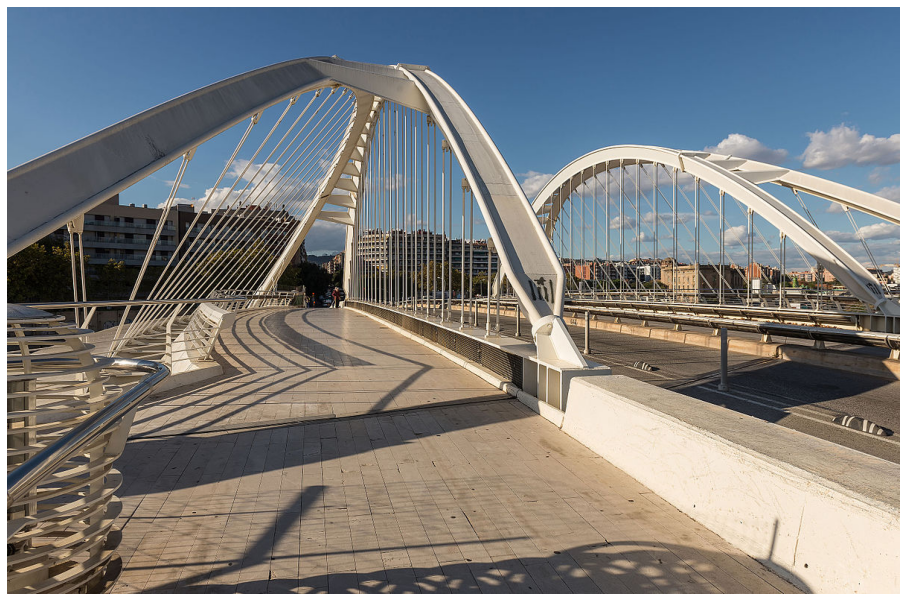

In [10]:
# read in test image
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/8/8e/15-10-28-Pont_Bac_de_Roda_Barcelona-RalfR-WMA_3105.jpg/1200px-15-10-28-Pont_Bac_de_Roda_Barcelona-RalfR-WMA_3105.jpg"
image = url_to_image(image_url)
plt.figure(figsize=(16, 16))
plt.imshow(image)
plt.axis("off")
# Convert to greyscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Sobel Kernel: 
The OpenCv implementation of the Sobel Kernel generates the sobel kernels and convolves this with the input grayscale image.

Recall the sobel filter:

$$S = \begin{bmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{bmatrix}$$

Which can be decomposed into two vectors one for averaging and another for calculating the gradient

$$ S_1 = \begin{bmatrix} 1 \\ 2 \\ 1 \end{bmatrix}  \text{ (averaging) }$$
$$ S_2 = \begin{bmatrix} -1 & 0 & 1 \end{bmatrix} \text{ (gradient) }$$


In [19]:
def sobel_filter(gray):
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)  # x kernel
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)  # y kernel
    sobel_mag = np.sqrt(sobelx ** 2 + sobely ** 2)
    sobel_mag = sobel_mag / np.max(sobel_mag)
    return [gray, sobelx, sobely, sobel_mag]

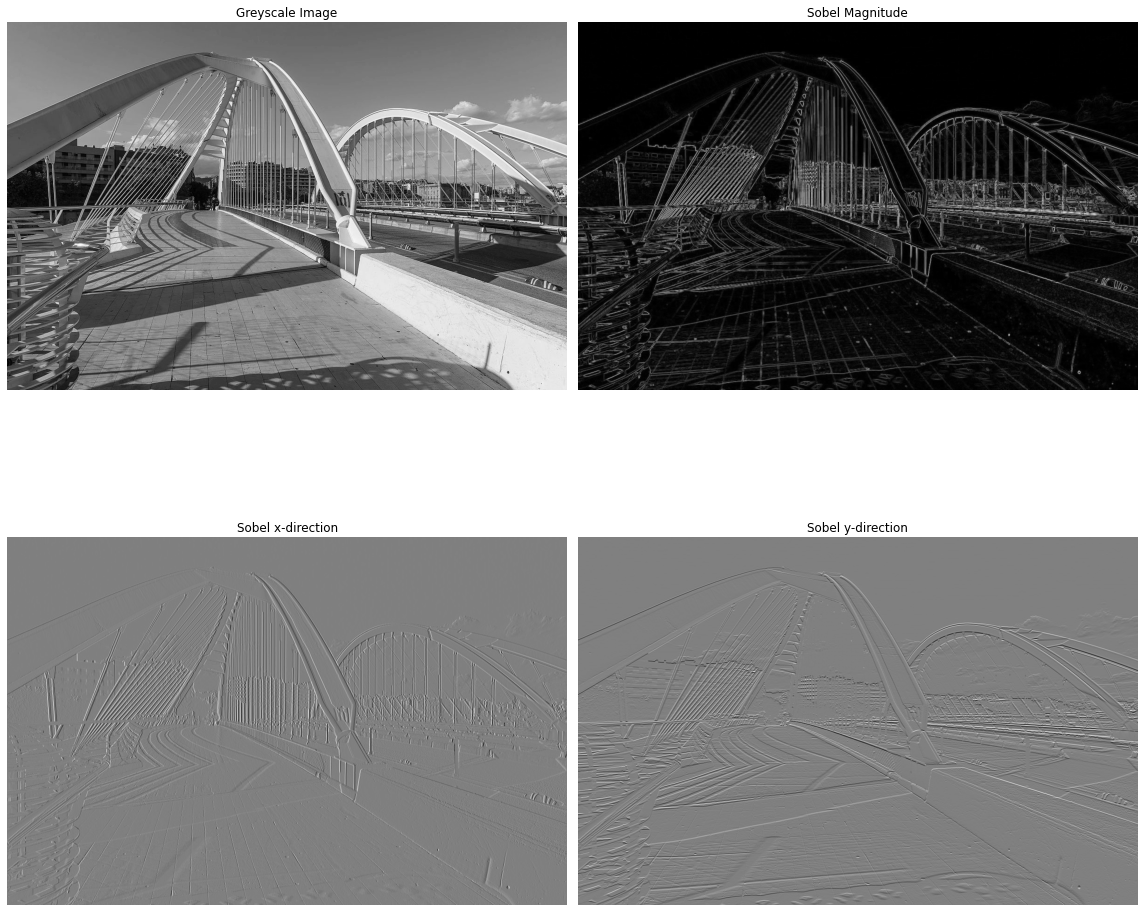

In [27]:
filter_name = "Sobel"
ip_imgs = sobel_filter(gray)
plot_img(ip_imgs, filter_name)

# Prewitt Kernel
An finite difference approximation to the 1st order derivative is used. The convolve2d method from [Scipy signal package](https://docs.scipy.org/doc/scipy/reference/signal.html) is used to convolve the input image with a 2D kernel. 

The Prewitt Kernel is defined in each axes to capture vertical and horizontal edges

$$ P_x = \begin{bmatrix} -1 & 0 & 1 \\ -1 & 0 & 1 \\ -1 & 0 & 1 \end{bmatrix}, P_y = \begin{bmatrix} 1 & 1 & 1 \\ 0 & 0 & 0 \\ -1 & -1 & -1 \end{bmatrix}$$


In [30]:
def prewitt_filter(gray):
    kernelx = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
    kernely = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
    prewittx = signal.convolve2d(gray, kernelx, boundary="symm", mode="same").astype(
        np.float32
    )
    prewitty = signal.convolve2d(gray, kernely, boundary="symm", mode="same").astype(
        np.float32
    )
    norm_prewittx = norm_img(prewittx)
    norm_prewitty = norm_img(prewitty)
    prewitt_mag = np.sqrt(prewittx ** 2 + prewitty ** 2)
    prewitt_mag = norm_img(prewitt_mag)
    return [gray, norm_prewittx, norm_prewitty, prewitt_mag]

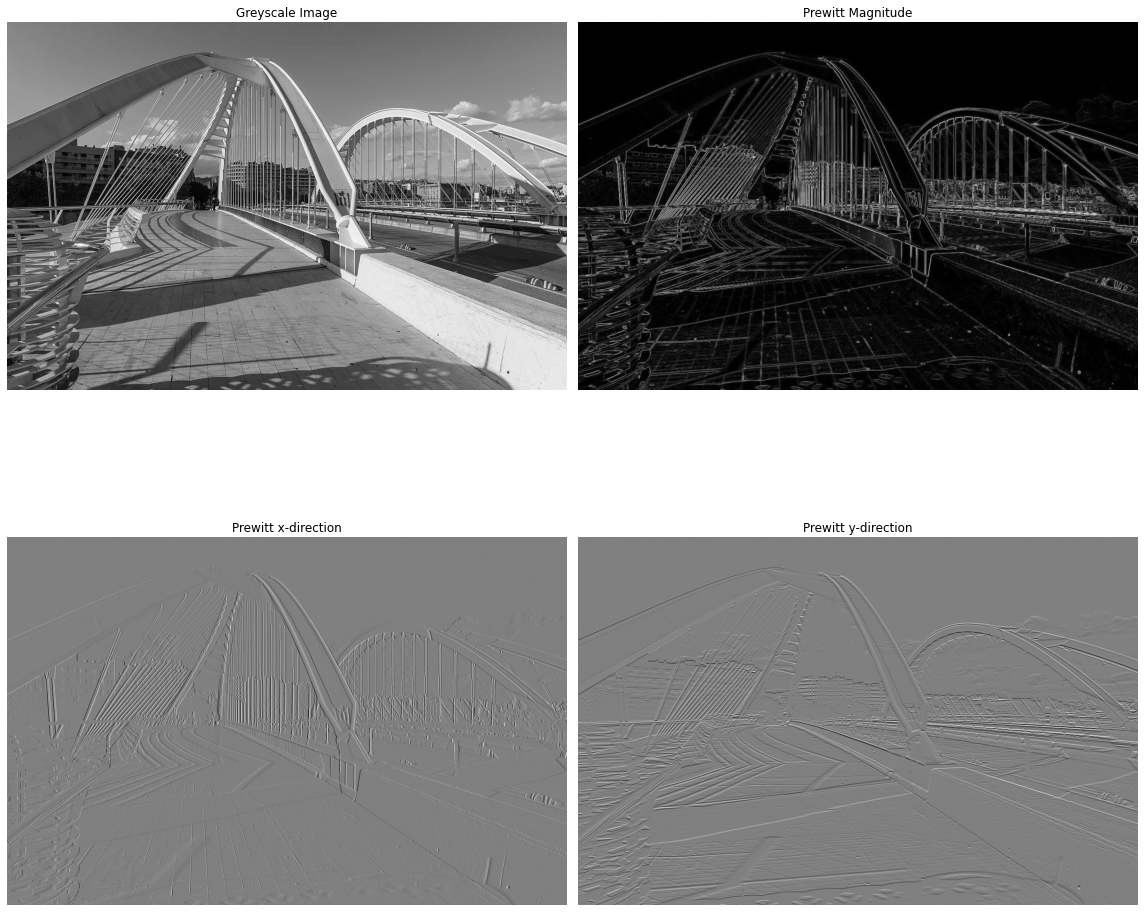

In [28]:
filter_name = "Prewitt"
ip_imgs = prewitt_filter(gray)
plot_img(ip_imgs, filter_name)

# Derivative Gaussian kernel
The gaussian derivative kernel is formed from the outer product of 1d gaussian and gaussian derivative kernels. The value of sigma can be adjusted to increase the amount of smoothing.

Recall the Gaussian kernel is given by the Gaussian
$$ G(x, \sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{x^2}{2\sigma^2}} $$

And its derivative
$$ G'(x, \sigma) = \frac{x e^{-\frac{x^2}{2\sigma^2}} }{\sigma^3\sqrt{2\pi}} $$



In [36]:
import math


def gaussian(x, sigma):
    """Evaluates a gaussian at a given point."""
    const = 1 / (math.sqrt(2 * math.pi) * sigma)
    exp = x ** 2 / (-2 * sigma ** 2)
    return const * math.e ** exp


def gaussian_deriv(x, sigma):
   """Computes the derivative of the Gaussian at a given point."""
    const = -x / (math.sqrt(2 * math.pi) * sigma ** 3)
    exp = x ** 2 / (-2 * sigma ** 2)
    return const * math.e ** exp


def gauss_kernel(sigma):
    k_size = int(6 * sigma + 1)
    range_ = (k_size - 1) // 2
    x = np.arange(-range_, range_ + 1)
    gauss_kernel = gaussian(x, sigma)
    gauss_derv_kernel = gaussian_deriv(x, sigma)

    gauss_derv_kernely = np.outer(gauss_derv_kernel, gauss_kernel)
    gauss_derv_kernelx = np.outer(gauss_kernel, gauss_derv_kernel)
    return gauss_derv_kernelx, gauss_derv_kernely


def gaussian_derv_filter(gray, sigma):
    gauss_derv_kernelx, gauss_derv_kernely = gauss_kernel(sigma)
    gaus_dervx = signal.convolve2d(
        gray, gauss_derv_kernelx, boundary="symm", mode="same"
    ).astype(np.float32)
    gaus_dervy = signal.convolve2d(
        gray, gauss_derv_kernely, boundary="symm", mode="same"
    ).astype(np.float32)
    norm_gaus_dervx = norm_img(gaus_dervx)
    norm_gaus_dervy = norm_img(gaus_dervy)
    gauss_derv_mag = np.sqrt(gaus_dervx ** 2 + gaus_dervy ** 2)
    return [gray, norm_gaus_dervx, norm_gaus_dervy, gauss_derv_mag]

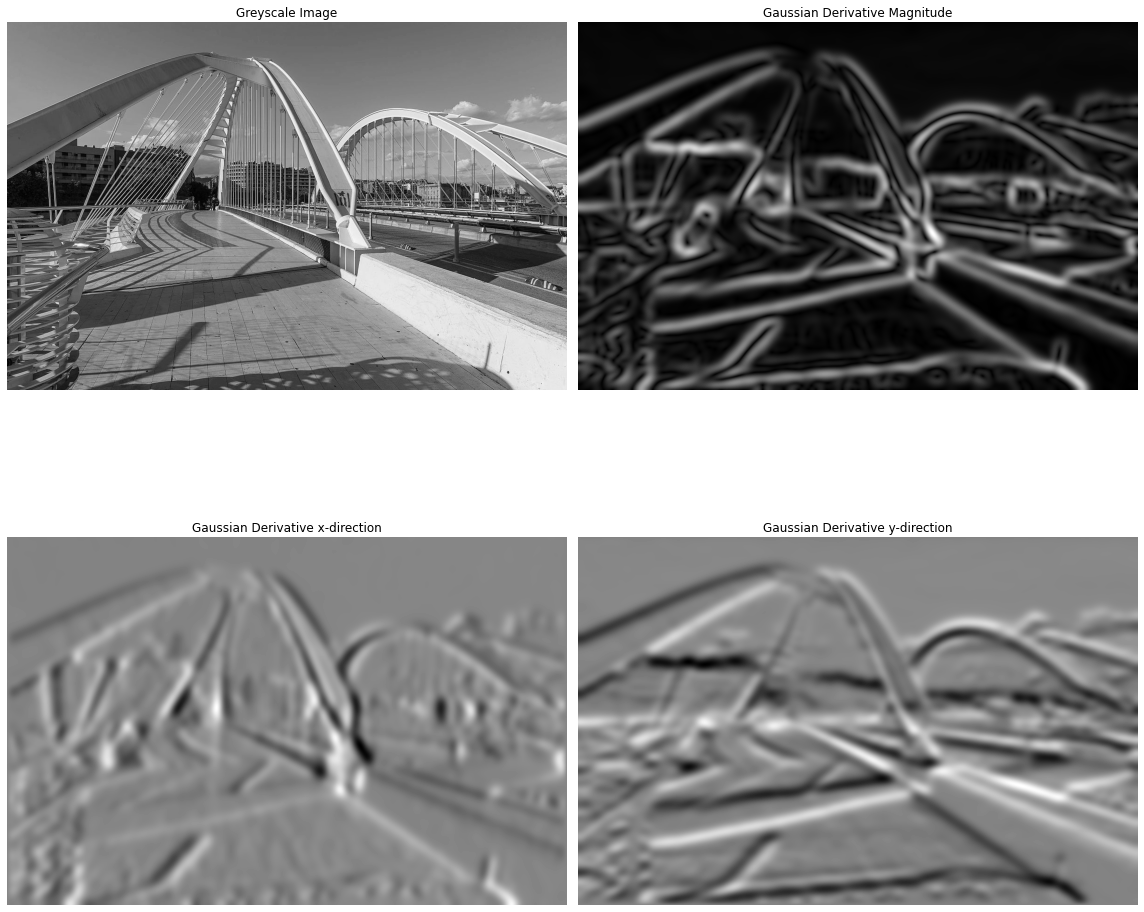

In [37]:
sigma = 10
filter_name = "Gaussian Derivative"
ip_imgs = gaussian_derv_filter(gray, sigma)
plot_img(ip_imgs, filter_name)

# Laplacian Kernel

The lapacian kernel is formed from an approximation to the second order derivative ([link 1](https://homepages.inf.ed.ac.uk/rbf/HIPR2/log.htm), [link 2](http://fourier.eng.hmc.edu/e161/lectures/gradient/node7.html))
A different test image is used to highlight the black and white lines produced around edges due to filtering with the Laplacian kernel.

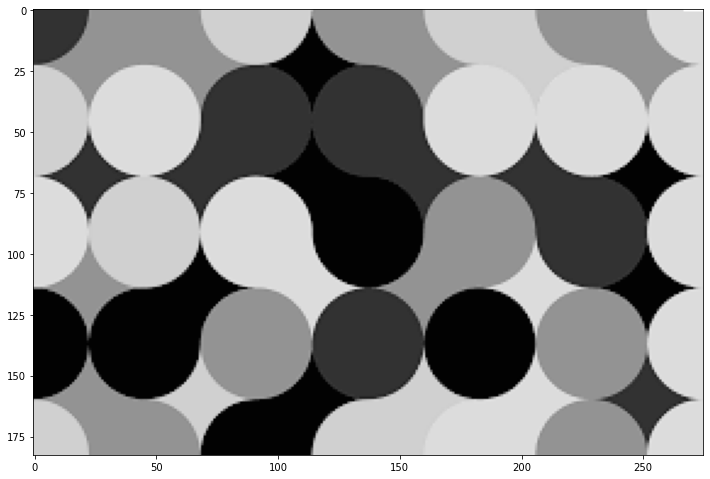

In [40]:
# read in test image
image_url = "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAARMAAAC3CAMAAAAGjUrGAAABWVBMVEX/wgDoiAHJPABzAEa/uxH/xAD/xgBwAEf/yADnhQHmgwH/yQC8vhJuAEjIOQDpiQBrAEnrhADvjgDHNABnAEnqjQFkAEnPPwDFKwC+whL+vwDzpQHDwgvBvg66uhL1qgDdlwj4sgDumAHefxDMRgDhkgbkjgTskgHHsg/6uACoTDLUowvYZAC+NhTgdwGrLCbcbQHZnAnPqQ3TWACWIDSxLyGbIzHVdxjLrg6VODrMbx6LLD5+GkLCtxDPvQ64MxvQUACNGjnevgvamSHGgyvDkw3HVwW2cDGuZzTFdwmCKELusBTEZyS1qByFRj2lWzeKUTuBOT+VajSdQTeokCeumyOffy6gJi2CEj/RjyZ5CUOdUTqWRzyNWjmPPT6wVC//yTC0hyRzI0SjhyuadDG1XC3pvwm9oQ/DjgzDTAWyRibGZAfBcArEUxq4oh6zbDKoOSx6MEHXrQBXmdMTAAAbiUlEQVR4nM1d6X/TSNK2LUuyJOuwZdmKD4wT53BiQkKAhBBDIOHKAUw4Y47s7gwwszM7vLv//4e3W5JtHd1SFQu/nfoInXb101XVpe46cgU2OXkELZaLcOpcUxBTK2sdxNzlyxi2lWYuQn8LKPc9MFlCYfIAhwlmbiwmYo5JbEj6KEzyKEz+bmL43kRhsonBWx1gMDG2UJhUEGwX22cYTPKXUZisoWSwh8JkiOK7soLB5B+YqfMOBpPiTgWDSQuDib2OwkS5hjGE9V3M5CgZLBYxmOSXJQwmKEhQAt55VbtAYXINA0l5EcO2gpATYwuJCWIz2x/0vSpm7v+BQfkOqoPazI4u1Lb/Ksozz1Yepu7gTuI8wkPpvNYF+QVGUH6kh6KyPRSWmGwgxYRs5g6Q5/ZYEITaAuoHUCfPCHXysAWFgQnSYfMIKChtIiaCIN/6gYLyHdy272BNKFVgjI8oJERQcMfxCIFJsYjim3kcJw+d4TeICZDx9k+y4FMeAwrqewrrtzFASUCy/02QEIcTAMmZHkAi30ZpD/KjBwOKyjiP45D0v0FxfMYzbwzaP1vChHTU2QPUzAkol1GSkjQpcUhQQh2dPAOUMCSCYP2FQYma133zmyEhky+lQvJLGBICyq0q4rcqP1B9lJ7Ex8T+NvMaohUe553iU12Ikr63gBCVymIRgUr5WgVxJKstSWRjYvfV/0JIAs43mZx32i8FWYiTXLvAiIpyDQPKCKM/yvIgjMrEkNj9Dee/hoTMnl9LoNJpv/opLiSBqIxPqnBYKks7ZTgs5ZVFhKyo880ZKgQOw7CNrfXvgQglRdlcKQe8dzqddnv0+shKCsnEqggXCwQWE2bHKs7aCA5LebSZryhAXBR1vidKokiB6ff7+8N1MxMRRVHUvGkqqpr5K0rFvLy2MyJ0+urns39YbBmZykpt/OLT7raq5AkT2WxUljbXdlaIg3iJUCYq5dG1zctLZFbCdSY4irrc6vaaudzcXHm0s7aULmZ0dK8pSoTEQa/lqGmjTcdZH+43XI/uXr0u8KWEGhVdv/fmxhWbUoHuTqrEkH2ZJ2x7uyl+vn8nA5ZLxfufP0seNXut5VS2ydxOqzegujPBcy3PtUmq020GUkVZEUVp0OKibjrqsGAbxtR0Nxp373FRka23NwqNmXtk2HaKFhP5HpBdCZ8Rn+9wUbl06X7IcFK2c11H5SKSb00XOROza3nmOhWnJ8WdGqJ4HFQcdd+e4TGBxbjORsW6d6URH0ysPQeViB2cssJD5dL9+FDKd89hLzLfFWdYh5WP5enEz+7p9Ln55OymuZVExEPlytukVZGFuwlEAtdRSYKiOAMOJ59ZiNxhXyuKUpcBijofEb6ISVpJMGIOOHfbuVxydkctMBHxUHljJYSEN5bo0Hrce+TtjUcJUbn0mTtYaiZEJe7IxiZbioxXlkU+IzlxEINk3eaukoByI+bbv2ELSSAqMZdajfvfUbofAyVtsCguRxfpxG8g40IXBkXhPYBMZm+GRdzZSIOE0N2w+lhX0yAhoESeIhOfJHFOoqCkbCQlKaL2Ti4+PKGJS2BIKCizydOlxAfFAkpJXFJYlxx8UC5lDc5JIUkxE5AkMRlNh5uZcxP1mRxuppoJSaFxdQKKfj0LEnpVPgFF6WZtDuHkzsyWZA7OiVO8WcEFCUzKk7s77rN7mKRuAIqZuUYKyj1ffeRxNiQElOCblHO7zlkJ6wxOYtJUUyQwgcnk5pt5U8kAZdnXnC3uiROhQHOugAYHDwgKhA/ivgXaAxocHJpsuJOYFIvecBMESaA9ZrYx8ck7fCCaQ8nwHprULkBeKd2Bao4Hioe32mT9HwMS79E126xNJqdG3OnDxKTQeEscWh02loBCMXFgm0O2hwrKHejgnsLVBZacUEEBiokvKGAxIYKiC/JNmJj4cTAKVEw8QbkEZdsTFJX9XyxIiEXhxqswJl/Om0BrQqgBtiYeOdyACAYRizICjxa7Cs94M+VkpcJWNN7kJlhMCoWb+luomNA3Sd7bP3sxoENnQirPPjAxKXNDeFjUVDbAYkIct1qmuzYjY5iH2jVK97PdtRlJyypnkWxMLsNVh04OVx2iPHWE6hT6eQQjuc+wg9gnscXbeDYma5jdEVt9xCobY8Tggo0RWOLMYgb3eBvPxKS4A/Fhp5N3Eeak0ECoDhaTHMac5Jq8E42NyQrcxFLAXczW38UMRmICdNgC4m08GxP4kZZDY4IxJ1hMMGwTQeH8OxuTrBuIKCM4TFCExOT70PeQky4KE8QZhcYEo/JYOVnBTC22MDYWqTt51LmDOS5z4jHGnnS+YM4daR6FyVUUJuslxColjNMrNg9QmDxA+Wx5FCb3MGexMcRgIq5jMDk+RPlsTzBqXBpiTERDQBmUgoZYZW8LgaB0/pgzmonJ3MMNxOQaapFG/QZmuIvQYmnZRbBdenzEwZttY10Dvj3Io/iqBbxl8wlz8JSGLvyyJaeN6xy82ebERkxeAtzYz6hxTxZQBmULvDtizkWYZPG4ZnEMClt1DAOuPCXECskaLUH/QcojLdsFGyxVpce6zFEelpjsEGVweUmVCU5QJ3HjpizIiEslzGms9Q24qolNSxBqm9D72LnfDQQrGvR62iODPvBYqM9A6O4EmwNl+xHhRP7IFBSGmHzxbCZQZktLKDG5LoOfvKYwbsAsiuSNtvMgUMRBjT401Q5g7ztlf+Nhxk1sovy14MVYR92huKDXNy14O4DtpfYxCBJiBU4kNeePYJW2AgBFw1w7Tp4BcVf3ZHsA2iO1Ao/A2AcIinZYCx6u3zEWmYDk16m3AdgfDf6wUwgevAJCYZLtnoqDKSN2tq6VNusTPmqHydFxxXkQcsDcjKiPnJbHuGuTF3T/FR0Dij3MWKbYDFl6V80YLR2HwoPq54nRMSl5EFmk3U3doG+HhIDyFgdKKU19pGbk8MsApXQcia1LghKF5Dy2SHeeP7uoraOc+liUnzzG2BR7K8eX2VLPiFo1dyMFQu2gFmFEqD/SoqPDelP8PbFId0Pi8FIa7CNsSeNuIglB1jPCtyJkFLoae52i5rhxQ2/3BxwJl0qP6zFGBOtjMzJ65pbM/WozFmkXWloSFVGS8glGUhApXI9HPXq8vE2Gx/LJ3Wgydl/Ueqy9MVxVYgRKStrBmBHqLluH4UUGgJTLD/rsbTfcfYJKZHqxJC4V4ELSMG7q7EBqmRU0zCXbVptRTkRJ6w45e2MbTq4UHV3SDj7WmIwI1t55qTSBpXipU54rf3lisIN9PVTsgtolf0HdG5GwIbY2WBIV+yOa7WEYjYZx9V5KFoJsvb16pQHFxXaH802NckL4kEpaz9lPkVbb3WjlyGiPSpp2/Ghc44f+W/rjTUnzULyzs/bkN9fNWKPtuvsLm58/fz6+vN7PHG2Q4f3hxvrGw3/eE+opfHio6Nb43s2rV2/cuAsAxyAzbzitbq87nx/aLn8jJ4zsr+fn51uL54/e1+os/Q2RXq8fPT44btKdLzVbaj/NOthu/8mXYrlM00PK5dGDP1KEio7ecroEcUpkc86fWamJGR4usk7J0t/e5ISbTxe5v6GaNHGGhvuvD/sZoNC/CMi4+2acxohcG389GEy1jcCidTd4qNjuHztz5VDVF6JsDx5yR9vqIKz0RNek8yOOFjPAsYQ3Bg8Wu79hOqFcFpMmgRgIU3+FkwtBfrj+blMrxayyqA2GLHfDcP8YzSXK4HTmvvzGUiBi7sXE4SBSa58htyHS9ZvMFRkFRnYewWiYKSshVAzmASjU3h8zTleKSiuJud3/Mpf8dPaP7qSo2PsDtrMklR4lvIIUVIQbSVGxtzjZTo6CucFpXEkexrJ+wPF9COe5rdjm2793uKWSyivx05v41Fz3UdvknMdMSt5jJzM1QrIyxN0Ix0RFv91M+YQRtWgegfuELSSBqHQeRkenfAgQwAd7CFD06OeQUUjN8wXE+odBiabNWO/4O+lvZ3h29zwNkiK9zA6PbqV/0Ys5DCixb0RGktN3AsV6lnm1EJIUO1VKfP35barK7nzWJYfYhEMiRG6yjQxIAIkyPFD094Cbs9J+sEz7YSYkxeJogom9nj23dIwwtKEIdEiVGgf3QHsvEFl5LyV9bLabg8klXjYi0wvtgrEPub0tHcKPZCLVwTsQrEoNOLzdp+A36segt4+S44mh+wBUnC+4vnVhkR/abYRJEWSffVh9J0gCUYj8TDzrEfCV0XuxMSCa4xFlBfoaJH6D9kDrO5nfoD1j6Hua93jkfgHWcCw/sRGvhto7jKBYBqqYEUp5rhBBsc7BT6ka+dIHi0mx6CLeL8Vj6KePpzzXMWXAkGaWPiLAQzOkvG3DrAmlud9toDXx8D5CWZQGoqgg1qLo+iM4JuToccFSQo+ePjxapXSYXuYiSvoNTGk0BxPjXijINV6QH3Mz+wjVKXZcFYE3UnkMRAU9rJUVEHFhudL6OaJOz9xvsHTKAG+M7gjjBqJUDSLdjNKbZ6iYymXoqUOp/AcmclR7jzp5cMUncQaFF/fIJLGFqTDd+RUzd+kryqD8C1PSyMFAUrjCDLTgYtLLLMsTpi+Y6GUJZ2RxmKCMrIsxsblcE4XJCgqTc8w3j/4Jg4m5jzGymDBTSihMMNlVfyVMoM63T38dOTlB6Q4qQggnJ+IAg0nnTxQmBz8OExOTwIq0J2IPU9q38xplv1FOm4WqcZ5HeffIc6cLrbntYfIBJ4SY64Ja5q1jRHdQmURI/2QeU6+1/W8U4KivwDGqP8D8ABMlhPRjHUyboU4N8X3pBXWDIUGWwm9pCEga98aYPJimiug+0Hll8ZI+2IDHY6dSyEKZWHVQQnzxNFDfxWJLQXR7aH/AfXTnSnDd0VEW1pHEFlx5cPcntDQIQnl0QedlTLExeQRVHn0VpTpdERH9713IwvNgeiqiz1DnF7LCGsYlFJtQ5UE2kRD9fBUY4e5j/VJDYEGhmqB/RV3PAD+NcQXf/YI6JWD+cnBvD2Rb9EtSAduCEGtC2a9jLIoowiyKjnNOvD2XgBbFz4awDmFZHNPafCDN+dP31OXbuKMH4rfVkIeOvysa6OW4MQ5+A7SXQcE1IougDkmTBYBf1HzGH2d/9CA1Z3L/KYoAMzuNc5ePUoPWA0hm9SEBzQdmTUGE+gHm7NE+ZpkU+QgFySwDPZSiwYUkFFfASlaJQdIKVSfOBKX9NGQY6psIUETpdjoo8h6mS0WkXKfUywjxntWdpAL+OCuLoxUprZoOSqcd7W1QP8D4ytLHNPXRjzBdKtRonQKplxr2F4HEC8pJK5IbqzZLQEmxKZ1R/GMukeCQCoqWTAaYUu0FpkOCGn9LkZop+RGNeOij9ZGb8yFKAzNRq1lZ4rTA6LR/TgbtWR85cY9M0g5kTnsE/QRhS1j1ocWSytEfVtyjLrDjHkWpOc8sdM5sgdFpnzLbPci1QwmOiiR+rSVn0WurCFNCKw6yfrDU22Kg0ijcZEYN198N4qjQkvXzvIr4SmUz2pCh02m/esoLSLbkw1jyRAqJpeYjOQKLbMmrC2C9URSzxauhJNLQ8IhdaTSu3NQ5ll2uPzuexlHTqHhxkN7aQKksrq2Uy+12p02o+OpsnBbrqtffHx6XSpKXPZFZM7lUOnh8VLP8ePva3upuZlMR2lzDa7GhLLc45d2niM9vFFyb5ocQbK68eZsWb6/Xjh5tih4sX78+2l3IbOFBmFjf/Xp2dvbh6Z6VGfxr1etvPz1ZbLVa3V5OysBF1DStu/CvG1ev/vPherWa0TGDMKLsnlysrl58PT/WtAw9FUtaqbusbmwM/7V6VK9nuER6vT728jK87RFenJj87SH/dXJLr+m6TCkDDyL944ttb7Np8oSqOqmbKWqD/BbdSirchmH3h2oKKmZ1e3UvECrCdu39YcIMhOeW/NYeZiBZu6tprTss69lBzlefyULkVYVj66sLq9miMaXa7bj0K6rT5aAiaq1hLAeH3xqCIHJyVItwIlv1d8e8NEGx60T7VxBcTvY4TpElHIpTMzj9V91idk0yzVXG2cAjfbzLmkR1mJnK7LPBQ4W1N7t7jG2WyZHB8J9Fqctq/0FgFVj5gLXDUkgNIwvaTohKdZc1B49qqzwNVOcT54Oo8XwIwx4mRMU0X3BuosiCEqIiNuPeZ9o81K0K/3V0TZ9ioFQvMI8x1i7f1SKeVSxhKJEEEkalH7s6MRdY+Z4Ttt/HdFMapHQgqp7E84sfxzCNzR69AK3ewrxjyuk3hdE+fOIg9UIslohhbqfmz+lHkbvPadF9DijbkVXVExULYrNHWhlWb2FCRTIgiTYREAdZOWtGCBRzO+MGV94LqWYGJLHpkpDEMRFqF1NQqi8wUgLoXj2TFDEHuPiZevjmQiYj+u2pRfCu2NOpujsFhXUXllzbpI9uQu/SIQF9tk1+VUuxJTObMjl9zHG2KzBNwwn3NeGDchGgzExVSc4u++bNXEAFbYLaNE9uw0oO5CKZVrf3FvACosL14NF6eneaDkqQDCGzPpcYy/NNShWVQqHDPmX96uki8KnbbyJi7sI2R/a7wWUZE5+CHa8xH3gYk3uWwURpjh4/xLm8UB40YOiMn35QBabM6V89kwLskVhd1bmvDSzAacPl6h4CEkEAf913RUQxRJp/YJ5ALT19jBRbQExMpcatz8acnHwoAwXWJ/0CfC/mSDn44z8VlCo4XIU+iYtQPoiVkgVOPARz8tVq9RbGmiDedcl5LMLjIWyUqR9rXrcUGBEnhVfvkT171UQ5sIju5kqrhCiGaGxUL+B+Y22zxGhayKMqty4oe/KFXVRw4gXikt2BPV4GmGzBVYcqj4bo5Fx9wQslYk9+gtgd+u2HeXgooRI8HYRdk99D/LUJmSe8qBn25Ks4c4J5/1dQJXhtnMDCzQk1KLy4RzYmt44QnAgyLjgRlVDyT4zA1uYxjCzwwjXZk6MgEfYwmCCz9v4PhQkqrknhxVmwJx9jIMEcO9j478ZNlGFDRV0rvFBnzOL/B5gUbqKywjDGPq/wekOwJ0c59vLHHygnKN3ByQm3USZ7lbcxyiM/R2FygqrV/AxlT5ayf39G3C577FW+wFwUyL9gMKmuYlTH/jsKE+gXoLc5Kq+7BnNu/eIFps7Py0UMJkcYTNxTjH+yN8Bgss7r2cKc29r9hNge63QT41Jj+r4Zv81hNueZBLpQCjAZ8vqTMCev5VEXj+1rjObyPE6264gC3faT9nM4KNa5hshGdvZtBCbkcK3Cjax81i7CMamuYvpIul/aP8Mltt6UMAaF2wCDNbd+Yprwj0Drz075MhyTsVfVBEpzxQ6YEfm9Nuu7nUnEJ+CVKGFiYhKjDFaeozZtUArlhHzTcWoXslTnvDwJXgcQLeAPu7WnRPOzbXaQEwsSepNYhZ48+stOsViGOgbedYgMxoSGio2gJw+9DgE8eAWbQy9AOU0TGHPL3gsC0MrK/25TxoGC4l/z6sAGxrZXXQMqKP4DD1RQ/DR+m5ljk5w7CP2fPpWlk3XqVcAoXwYZt8B0w9ogGP0gshCESfCiN+3+ngGJf9nH7g+QmHv6ogd6V9HP2kE0JAiSVd9gwrrNuDt+wZHOS8ju6MGWR6LjeWQqgZ1n9npIQDKevOiZC9kWX/5pAglEe2Yv0JAu8e6vkwDU9lk2J/XpU43EC8cJYzK9/2RpTwLu2bVMZoQDAXAWNVvOdNzC81mZte3tP2bli2KB/SxIQhETopMFijOr9WD0k3GZcUjCX9vVjIcveTwKldMpr6WDEpW7LFDc38MVndrMqG02JOR8zQAlUurB2E8EIEYXKUQv76rbqcHBR8VIhaF0SSFzRf7aSnXx45Vr28/TQInF1Yi5NPUxYxVB7P2mxMfEuh2/gDcX9ri8WB/axSiVV1ixhv5E1U9xmUvpiWe4D+J1v9qvudFburwZPz0kdu6AJySJUs2GEWuVEpra+pSMWjSrF+z69LrwMg4JpctMUTGrC7eTZ4c+ZhduN9yHo2TaQ/v0iLk9cv0dI9VE6iVzTDxOnA1G0BhtJMHARK+9YAcNVxduJQNkdf0XdqHq8spiJc6MWc1fsDeZ1RrCcPsJIfGo0/5ZSKiyXv+4yc4zEVvJ2EfTWWd3wLAL86HECQ9qvTa+UHmhrWSTV4VQJLWsW0eviywhCVDZrMxgoUHd26vc5hCyde9uqPmBYdvu71+SpeOnqLz8KcqI9YyNiI9K11GVECeOucHpCeL1v3BoPok3mWVZ41sX29W0LAS6rotb4xol6x8fXp+2U6u3lcs7a4tO1aOFk9W91OYQsiVcv3rX9ch++ORBkYuIj8ro5w//tigjdeHjo4P0ZCFRanbnfV/fVNaH+6kZcYbtbuVbA4rK6crOfzYXK5m+BQ3iVxcWljbXdkZz6amTnXb71euzp0d7e0KtxkuYCYGiP//l5Z+nK6PiXKTdAgfwzp37n8XB8UDUtFJGZr1IQOm15pfNvLq+sdW308NPveYaTmvQzPkbW7y2CPiI81JalErFWWPYwBkiL5/rXg5HBhi+PZDP/my3O/wq+hG6VLwv+ovNzgyiUtKaKg/RHMdcT5EUw90KWrbMehKVR+wjg0lKZZGbJvg6aQj5iAivO+l6GEXkcxYOIWJkrpmOwmkkYbjD3szIzn6yvLIERyVfucxIEyy2X6aExSfIOgPKhw8JBhExx/RQTFNhZZTa+5HGWOFfzfLOo7Ki7MRB6XSeI14e5PEp9/BiIHIHVfCsx/MeTUYlfFeNmurID5d3EKDkK5tRUDojVPeHpyghuY9AJP2+wFFj2Q9uK+YGR3+6PELce8cysjunMLMaQPIcISQEEpSUpEe1mfmId28n8q3ivz5CSUoIlM4pqt7nD4UkKy8jH5aSZApa/OfL4Ct4D5SQ+iAQmdziQiHB2ZLsNx5TnbX5YFy0JRhAGdp8JbgfDFf9gGCCQIQQAhHYzf20SrPNasOZZKCMeRHPKwEkr1FxIi8R5rV4CVXSFBZJHVwrsdt8MHhAmZSgms4IlRH2FGdMMJBAX0dNwzcmLLwZTJQxYQJ+0TL4Y50nJqcYMcFpDuwpgz5mGNy24iwmUIKSp4ICfqvzxAR55qDEBBxcTut5c6rqsthAPIkTqoyKnTOUmPyJsiYYSHI58Bu6MzQMTqtoJh8od1ZZK7cRiAjCHkZMcMWug9pyEDJV2+YEbzH5KKOUZ2nuFcrCnqHEBPPlhwgroC/GLufCgY0JTnlwqqO/+oEHMSJ2y9na4uRlsDFZQ508O09R5gSBSPEH+GsTMjdUzj0dmxGcQfkPqi3IX8OcUF+WFwvK5gT10ZO/jMpERjlsRdRJDM6Q9EjlxQyzOUF5KIDU+TAmiefDNPpR3gklbg4ChxcUJtsoTM5QmOCOHVT+jsIpBPz/+sCjpRrzZ0cAAAAASUVORK5CYII="
image = url_to_image(image_url)

# Convert to greyscale
HW_trg = 256
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(12, 12))
plt.imshow(gray, "gray")
plt.show()

Recall the Laplacian Kernel is

$$ L = \begin{bmatrix} 0 & -1 & 0 \\ -1 & 4 & -1 \\ 0 & -1 & 0 \end{bmatrix}$$

In [41]:
def laplacian_kernel(gray):
    laplace_kernel = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
    laplace_conv = signal.convolve2d(gray, laplace_kernel, boundary="symm", mode="same")
    laplace_conv = laplace_conv.astype(np.float32)
    norm_laplace = norm_img(laplace_conv)
    
    laplace_mag = np.sqrt(laplace_conv ** 2)
    laplace_mag = norm_img(laplace_mag)
    return [gray, norm_laplace, laplace_mag]

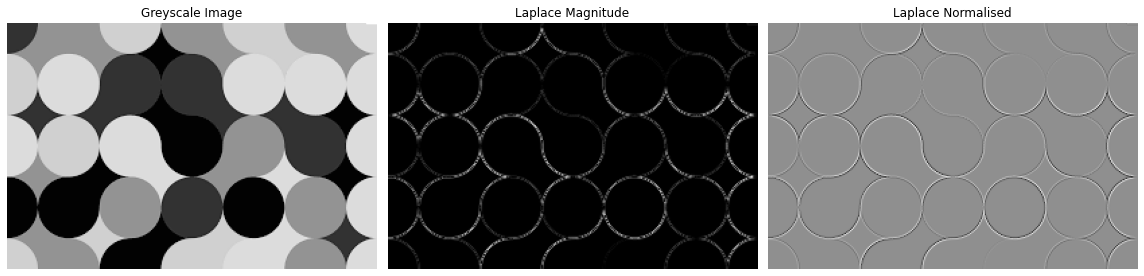

In [42]:
filter_name = "Laplacian Kernel"
ip_imgs = laplacian_kernel(gray)
labels = ["Laplace Magnitude", "Laplace Normalised"]
plot_img2(ip_imgs, labels)

# Canny Edge Detection 
The OpenCV implementation of the Canny Algorithm is used to find edges in images. A comparison with Sobel Filtering is also shown.  


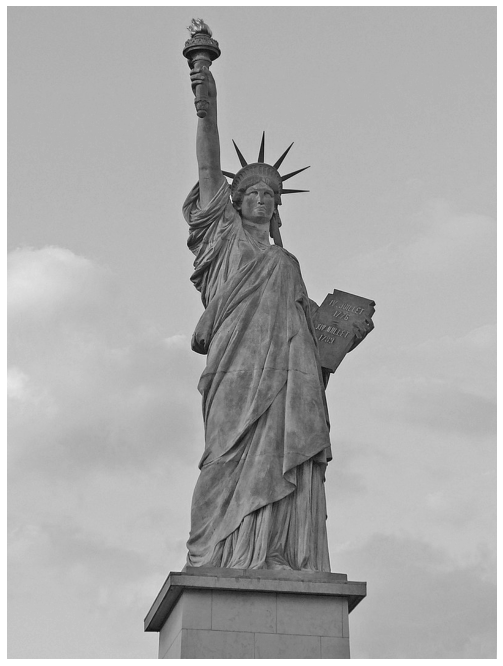

In [45]:
# read in test image
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/2/2a/Statue_of_Liberty_Paris_2007-05-29.jpg/800px-Statue_of_Liberty_Paris_2007-05-29.jpg"
image = url_to_image(image_url)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(12, 12))
plt.imshow(gray, "gray")
plt.axis("off")
plt.show()

In [46]:
# Threshold Values for Hysteresis Threshold in the Canny Algorithm.
low_threshold = 80
high_threshold = 240
canny_edges = cv2.Canny(gray, low_threshold, high_threshold)

# Compare Sobel
sobel_imgs = sobel_filter(gray)
ip_imgs = [sobel_imgs[0], sobel_imgs[3], canny_edges]

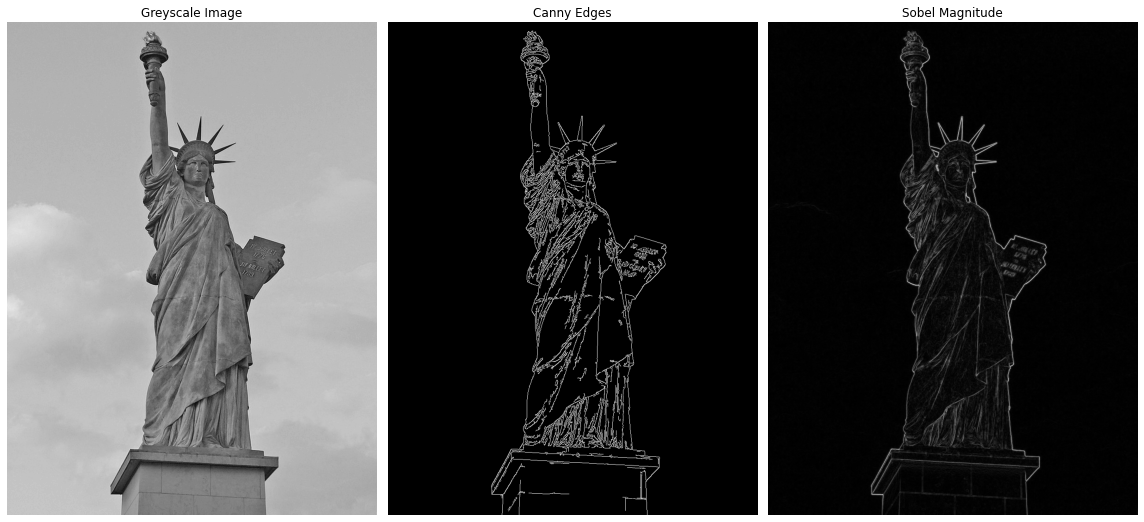

In [47]:
labels = ["Canny Edges", "Sobel Magnitude"]
plot_img2(ip_imgs, labels)